# TwiZlatan

For today's lesson, we're gonna learn something practical: Twitter scraping with the [Twython](https://twython.readthedocs.io/en/latest/usage/install.html), [Tweepy](https://docs.tweepy.org/en/stable/) and [Snscrape](https://github.com/JustAnotherArchivist/snscrape), packages, and sentiment analysis with [TextBlob](https://textblob.readthedocs.io/en/dev/). We'll also plot a nice [wordcloud](https://pypi.org/project/wordcloud/)!

The topic will be, as some of you already guessed from the name of the notebook, this guy:

![image](images/zlatan.PNG)

(If you don't know who he is, which is highly problematic, here is his [Wikipedia page](https://en.wikipedia.org/wiki/Zlatan_Ibrahimovi%C4%87))

We're going to grab Tweets relating to/tagging him, to get an idea of how the public perception of ~~God~~ Zlatan has changed over time.

## Lesson plan

1. Twython
2. Tweepy
3. Snscrape
4. Sentiment analysis
5. Event analysis
6. Time series analysis of market valuation

Let's start by importing the required packages:

In [141]:
import configparser
import itertools
import string

import numpy as np
import pandas as pd
from scipy import stats

from twython import Twython, TwythonError
import tweepy
import snscrape.modules.twitter as sntwitter

from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\fbindi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Then, you need to generate an application to connect to the Twitter API, which can be done by going to [this website](https://apps.twitter.com). Store the credentials of your application in a safe location, preferrably an .ini file. 

You will be required to apply for a Twitter Developer account (and possibly to upgrade it to gain Elevated access).

In [4]:
config = configparser.ConfigParser()
config.read(r'H:\credentials\config.ini') # Your .ini file with your credentials

api_key = config['twitter']['api_key']
api_key_secret = config['twitter']['api_key_secret']
bearer_token = config['twitter']['bearer_token'] # We need to escape the "%" sign with another "%" sign in the .ini file
access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

### 1. Twython

We create a connection and perform the search:

In [5]:
connection = Twython(
    api_key,
    api_key_secret
)

In [6]:
results = connection.search(q='#ibrahimovic',count=10)

The [query](https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query) in the cell above is quite simple: we are simply looking for the first 10 tweets that contain the hasthag `#ibrahimovic`.

`reults` is a dictionary of dictionaries. The actual tweets are stored under the key `'statuses'`, which yields another dictionary; the key `'text'` gives the text of the tweets.

In [7]:
for i,tweet in enumerate(results['statuses']):
    print('\n')
    print(f'Tweet{i+1}')
    print(tweet['text'])



Tweet1
RT @footballitalia: Luka Jovic expressed his admiration of Milan veteran Zlatan Ibrahimovic and reflected on his ‘unhappy experience’ with…


Tweet2
RT @GiovanniDElia11: Zlatan #Ibrahimovic questa mattina prima della partenza a Firenze si è fermato a scattare foto con i tifosi rossoneri…


Tweet3
RT @h4kwp: 4K #Wallpapers 
   └📂 Football
      └📂 Random🔥
#DavidBeckham #beckham #zalatan #Ibrahimovic #bale #cavani #ManchesterUnited #Re…


Tweet4
Zlatan #Ibrahimovic questa mattina prima della partenza per Firenze si è fermato a scattare foto con i tifosi rosso… https://t.co/YH9mD2AX8K


Tweet5
RT @GiovanniDElia11: Zlatan #Ibrahimovic questa mattina prima della partenza a Firenze si è fermato a scattare foto con i tifosi rossoneri…


Tweet6
Zlatan #Ibrahimovic questa mattina prima della partenza a Firenze si è fermato a scattare foto con i tifosi rossone… https://t.co/u7B9ddDVRH


Tweet7
RT @cmdotcom: #Fiorentina, #Jovic: '#Ibrahimovic è il mio idolo, gli chiederò la maglia. La ve

### 2. Tweepy

This package allows us to connect to the Twitter API in two ways: the `API` class (Twitter API v1.1), or the `Client`class (Twitter API v2.0). For simplicity, we will only use the `Client` class.

Let's authenticate:

In [8]:
client = tweepy.Client(bearer_token=bearer_token)

This time, we will exploit the API's query functionalities a little bit more in depth. In particular:
* We will exclude retweets
* We'll grab tweets in English only

In [9]:
query = '#ibra -is:retweet lang:en'

In [10]:
tweets = client.search_recent_tweets(query=query,max_results=10)

In [11]:
for i,tweet in enumerate(tweets.data):
    print(f'\n**Tweet {i+1}**\n',tweet.text)


**Tweet 1**
 The Magic 
#milan #milano #acmilan #sansiro #rossoneri #redblack #devil #puma #soccer #championsleague #uefa #seriea #pioliisonfire #pioli #weareacmilan #shop #storeonline #ibrahimovic #ibra #zlatan #zlatanibrahimovic #leao #maldini #giroud #tbt #maignan #magicmike #magic #mike https://t.co/J106eRLXJw

**Tweet 2**
 @LoadedLions_CDC
Feel like @Ibra_official needs to get himself a badass Roman #LoadedLion #NFT now. ❤️‍🔥🦁
Do you agree #CROFAM? 😁

#LoadedLions #Ibrahimovic #Ibra #Zlatan #ACMilan #CRO #FFTB #ManeCity  #asterix #obelix https://t.co/g6kWjnqZlS

**Tweet 3**
 Zlatan Ibrahimovic: "If I feel as good as I feel now, I will stay at AC Milan next year. I will also continue to play for other years." 🔴⚫️ [@NicoSchira]

#TheGoalpostNews #Ibrahimovic #Ibra #ACMilan #Milan #Rossoneri #SerieA #SerieATIM #Calcio https://t.co/WVIiOE4GPl

**Tweet 4**
 The king is back 👑❤️🖤
#ibra #ibrahimovic #MilanAtalanta #ابرا #ابراهيموفيتش #ميلان_أتالانتا https://t.co/N4wnr3olEw

**Tweet 5**


Notice that, even with Elevated access, we can only grab tweets from the last **7 days**, and in any case only up to **100 tweets**! 

The `paginator` object can help in this respect. Let's also grab some more metainformation about each tweet, and let's use logical operators within the query:

In [12]:
for i,tweet in enumerate(tweepy.Paginator(client.search_recent_tweets, query='(#zlatan #ibrahimovic) lang:en',
                              tweet_fields=['context_annotations', 'created_at'], max_results=100).flatten(limit=10000)):
    print(f'\n**Tweet {i+1}**\n',tweet.text)
    print(tweet.created_at)
    print(tweet.context_annotations)


**Tweet 1**
 RT @KillerInkTattoo: Portrait of #ZlatanIbrahimovic by Fabietto from Or Noir Tattoo Gallery using #killerinktattoo supplies!

#killerink #t…
2023-03-03 18:00:03+00:00
[{'domain': {'id': '46', 'name': 'Business Taxonomy', 'description': 'Categories within Brand Verticals that narrow down the scope of Brands'}, 'entity': {'id': '1557696505548394496', 'name': 'Beauty, Cosmetic & Personal Care Business', 'description': 'Brands, companies, advertisers and every non-person handle with the profit intent related to makeup, perfumes and skin care'}}, {'domain': {'id': '46', 'name': 'Business Taxonomy', 'description': 'Categories within Brand Verticals that narrow down the scope of Brands'}, 'entity': {'id': '1557697289971322880', 'name': 'Sports & Fitness Business', 'description': 'Brands, companies, advertisers and every non-person handle with the profit intent related to sports nutrition, athletic apparel, sports apps, fitness venues'}}, {'domain': {'id': '65', 'name': 'Interest


**Tweet 100**
 RT @MilanPosts: 🗣️ #Zlatan #Ibrahimovic to #SkySport: "The objective is to help the team and do what I have to do. I have to be there and r…
2023-02-27 01:53:09+00:00
[{'domain': {'id': '46', 'name': 'Business Taxonomy', 'description': 'Categories within Brand Verticals that narrow down the scope of Brands'}, 'entity': {'id': '1557697289971322880', 'name': 'Sports & Fitness Business', 'description': 'Brands, companies, advertisers and every non-person handle with the profit intent related to sports nutrition, athletic apparel, sports apps, fitness venues'}}, {'domain': {'id': '10', 'name': 'Person', 'description': 'Named people in the world like Nelson Mandela'}, 'entity': {'id': '733773808478232577', 'name': 'Zlatan Ibrahimovic'}}, {'domain': {'id': '60', 'name': 'Athlete', 'description': 'An athlete in the world, like Serena Williams or Lionel Messi'}, 'entity': {'id': '733773808478232577', 'name': 'Zlatan Ibrahimovic'}}, {'domain': {'id': '131', 'name': 'Unified Twit

In particular, we grabbed information about **context annotations**, which are inferred based on semantic analysis (keywords, hashtags, handles, etc) of the Tweet text and result in domain and/or entity labels. Tweet annotations offer a way to understand contextual information about the Tweet itself.

In order to extract even more tweets and run some meaningful analyses, we would need to apply for the **Academic Research product track** within the Twitter Developer space. There are "hackier" ways to get historical Twitter data, that don't even require to directly connect to the Twitter API.

### 3. Snscrape

Snscrape is a scraper for social networks. It can scrape Twitter, Facebook, Instagram, and many others, without any limits on the amount of data to be grabbed.

Important disclaimer: if possible, it is always preferrable to scrape data using an **officially sanctioned API**, such as the one presented above. Scraping with other methods, albeit legal (in the case of public information), may result in excessive traffic on the scraped websites, and worsen user experience for other users.

In [40]:
query = '(#zlatan OR #ibrahimovic OR #zlatanibrahimovic OR #ibra) -has:links -is:retweet -to:Ibra_official -has:images -has:mentions -has:media lang:en'

# the scraped tweets, this is a generator (it does not return a single object, but an iterator object with a sequence of values)
scraped_tweets = sntwitter.TwitterSearchScraper(query).get_items()

# slicing the generator to keep only the first 100000 tweets
sliced_scraped_tweets = itertools.islice(scraped_tweets, 100000)

# convert to a DataFrame and keep only relevant columns
tweets_df = pd.DataFrame(sliced_scraped_tweets)[['user','date','likeCount','rawContent']]
tweets_df

,user,date,likeCount,rawContent
0,"{'username': 'Rossone40712708', 'id': 12676267...",2023-03-04 13:17:00+00:00,0,Celebrations \n#milan #milano #acmilan #sansir...
1,"{'username': 'yhawjoey', 'id': 101025689204266...",2023-03-04 12:59:19+00:00,0,Bayern got too many attackers options Paul #Wa...
2,"{'username': 'MilanPosts', 'id': 3014435937, '...",2023-03-04 12:30:13+00:00,46,📰 #Gazzetta: #Zlatan is Zlatan; he wants to pl...
3,"{'username': 'footballitalia', 'id': 18841928,...",2023-03-04 09:20:03+00:00,2,Luka Jovic expressed his admiration of Milan v...
4,"{'username': 'MilanReportscom', 'id': 10472231...",2023-03-04 08:37:37+00:00,7,🗣️💭 Luka #Jovic talks about his idol Zlatan #I...
...,...,...,...,...
99995,"{'username': 'FlashScoreID', 'id': 2884054731,...",2017-02-16 21:51:47+00:00,1,GOOLLL!! #MUFC vs St. #Etienne\n\n(3 - 0) #Zla...
99996,"{'username': 'DylanMoth7', 'id': 1691494645, '...",2017-02-16 21:51:46+00:00,0,closest thing to God #Zlatan
99997,"{'username': 'sanchezitk26', 'id': 514423772, ...",2017-02-16 21:51:45+00:00,0,Finally a hattrick for #ibrahimovic #MUFC #mus...
99998,"{'username': 'DjNormanAfrics', 'id': 300512122...",2017-02-16 21:51:45+00:00,1,Age is just a number.\nReally pure class.\n#Zl...


Snscrape will start grabbing the most recent tweets first.

In [41]:
tweets_df.to_csv(r'H:\Data science\TwiZlatan\Twitter data.csv', index=False)

### 4. Sentiment analysis

We now want to run a (very basic) sentiment analysis on the tweets we just scraped, to understand what is the public perspective on Zlatan. To do so, we first need to clean our data.

In [154]:
tweets_df = pd.read_csv(r'H:\Data science\TwiZlatan\Twitter data.csv')
tweets_df.rename(columns={'rawContent':'content'},inplace=True)

In [155]:
tweets_df.head()

,user,date,likeCount,content
0,"{'username': 'Rossone40712708', 'id': 12676267...",2023-03-04 13:17:00+00:00,0,Celebrations \n#milan #milano #acmilan #sansir...
1,"{'username': 'yhawjoey', 'id': 101025689204266...",2023-03-04 12:59:19+00:00,0,Bayern got too many attackers options Paul #Wa...
2,"{'username': 'MilanPosts', 'id': 3014435937, '...",2023-03-04 12:30:13+00:00,46,📰 #Gazzetta: #Zlatan is Zlatan; he wants to pl...
3,"{'username': 'footballitalia', 'id': 18841928,...",2023-03-04 09:20:03+00:00,2,Luka Jovic expressed his admiration of Milan v...
4,"{'username': 'MilanReportscom', 'id': 10472231...",2023-03-04 08:37:37+00:00,7,🗣️💭 Luka #Jovic talks about his idol Zlatan #I...


We'll first extract the username from user information (which is a dictionary, but unconveniently saved as a string):

In [156]:
tweets_df['user'] = tweets_df['user'].apply(lambda x: x[x.find('username')+11:x.find('id')-3])

And then, let's remove punctuation and links that escaped the query:

In [157]:
tweets_df['content'] = tweets_df['content'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))

In [158]:
tweets_df['content'] = tweets_df['content'].apply(lambda x: ' '.join(word for word in x.split(' ') if not word.startswith('https')))

In [159]:
tweets_df

,user,date,likeCount,content
0,'Rossone40712708',2023-03-04 13:17:00+00:00,0,Celebrations \nmilan milano acmilan sansiro ro...
1,'yhawjoey',2023-03-04 12:59:19+00:00,0,Bayern got too many attackers options Paul Wan...
2,'MilanPosts',2023-03-04 12:30:13+00:00,46,📰 Gazzetta Zlatan is Zlatan he wants to play a...
3,'footballitalia',2023-03-04 09:20:03+00:00,2,Luka Jovic expressed his admiration of Milan v...
4,'MilanReportscom',2023-03-04 08:37:37+00:00,7,🗣️💭 Luka Jovic talks about his idol Zlatan Ibr...
...,...,...,...,...
99995,'FlashScoreID',2017-02-16 21:51:47+00:00,1,GOOLLL MUFC vs St Etienne\n\n3 0 Zlatan
99996,'DylanMoth7',2017-02-16 21:51:46+00:00,0,closest thing to God Zlatan
99997,'sanchezitk26',2017-02-16 21:51:45+00:00,0,Finally a hattrick for ibrahimovic MUFC muset ...
99998,'DjNormanAfrics',2017-02-16 21:51:45+00:00,1,Age is just a number\nReally pure class\nZlata...


**TextBlob** is built on top of the most famous **[nltk](https://www.nltk.org/)** library. Both perform sentiment analysis via a rule-based classifier; this makes them faster than pre-trained models (such as [Flair](https://www.geeksforgeeks.org/flair-a-framework-for-nlp/)), but may worsen performance, because they have more difficulties in understanding sarcasm or jargon.

In [160]:
tweets_df[['polarity','subjectivity']] = tweets_df['content'].apply(lambda x: pd.Series(TextBlob(x).sentiment))
tweets_df

,user,date,likeCount,content,polarity,subjectivity
0,'Rossone40712708',2023-03-04 13:17:00+00:00,0,Celebrations \nmilan milano acmilan sansiro ro...,0.000000,0.00
1,'yhawjoey',2023-03-04 12:59:19+00:00,0,Bayern got too many attackers options Paul Wan...,0.300000,0.60
2,'MilanPosts',2023-03-04 12:30:13+00:00,46,📰 Gazzetta Zlatan is Zlatan he wants to play a...,0.200000,0.10
3,'footballitalia',2023-03-04 09:20:03+00:00,2,Luka Jovic expressed his admiration of Milan v...,-0.133333,0.40
4,'MilanReportscom',2023-03-04 08:37:37+00:00,7,🗣️💭 Luka Jovic talks about his idol Zlatan Ibr...,-0.250000,0.25
...,...,...,...,...,...,...
99995,'FlashScoreID',2017-02-16 21:51:47+00:00,1,GOOLLL MUFC vs St Etienne\n\n3 0 Zlatan,0.000000,0.00
99996,'DylanMoth7',2017-02-16 21:51:46+00:00,0,closest thing to God Zlatan,0.000000,0.00
99997,'sanchezitk26',2017-02-16 21:51:45+00:00,0,Finally a hattrick for ibrahimovic MUFC muset ...,0.000000,1.00
99998,'DjNormanAfrics',2017-02-16 21:51:45+00:00,1,Age is just a number\nReally pure class\nZlata...,0.214286,0.50


* **Polarity** lies between -1 and 1; -1 means a negative statement, 1 a positive one.
* **Subjectivity** lies between 0 and 1; 0 means factual information, 1 a subjective opinion.

Let's visualize the proportion of positive tweets by quarter:

In [161]:
tweets_df['quarter'] = pd.PeriodIndex(tweets_df.date, freq='Q')
tweets_df = tweets_df[tweets_df['polarity'] != 0]
tweets_df['positive_tweet'] = tweets_df['polarity'] > 0
tweets_df_quarter = tweets_df[['quarter','polarity']].groupby('quarter').mean()
tweets_df_quarter['polarity'] = tweets_df_quarter['polarity']*100
tweets_df_quarter.reset_index(inplace=True)

C:\Users\fbindi\AppData\Local\Temp\ipykernel_22852\295986209.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['positive_tweet'] = tweets_df['polarity'] > 0


In [162]:
colors = ['red' if q%2==0 else 'black' for q in range(len(tweets_df_quarter['quarter']))] # "special" coloring

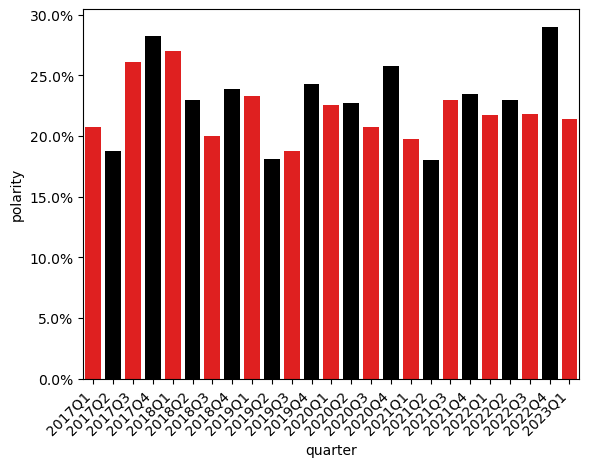

In [163]:
chart = sns.barplot(data=tweets_df_quarter,x='quarter',y='polarity', palette=colors)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');
chart.yaxis.set_major_formatter(mtick.PercentFormatter())

Let's now create a (super basic) wordcloud:

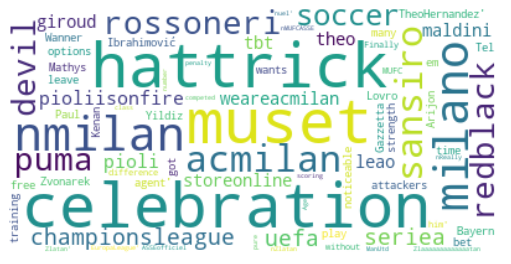

In [49]:
stopwords = set(STOPWORDS) # Words we do not want to see in the wordcloud
stopwords.update(["Zlatan", "Ibra", "Ibrahimovic","zlatanibrahimovic","n","S2EP45","Man","KizzDaniel"])

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords).generate(np.array2string(tweets_df['content'].values))
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 5. Event analysis

In 2019, I had double Christmas. The first "official" one on Dec 25<sup>th</sup>, and the second on Dec 26<sup>th</sup>:

![image](images/Gazzetta_first_page_comeback.jpg)

But was my celebratory mood shared by other AC Milan fans? Let's find out.

We will try to gauge the feelings of the *rossoneri* fans around the Dec 26<sup>th</sup>, 2019. If there is a statistically significant increase in mood, then we can infer that the return of the King had an impact (and it had on the pitch, given that in that season we had a point-per-game average of 1.24 before his return, and 2.14 after).

We will look for tweets mentioning the team and performance-related keywords, such as *points*, *qualify*, *league table* (in Italian):

In [150]:
query = "(milan OR #milan OR acmilan OR #acmilan) (performance OR punti OR qualificazione OR classifica OR europa) since:2019-12-21 until:2020-01-01 -has:links -is:retweet -to:Ibra_official -has:images -has:mentions -has:media lang:it"

scraped_tweets = sntwitter.TwitterSearchScraper(query).get_items()
sliced_scraped_tweets = itertools.islice(scraped_tweets, 1000)

tweets_df2 = pd.DataFrame(sliced_scraped_tweets)[['user','date','likeCount','rawContent']]
tweets_df2

,user,date,likeCount,rawContent
0,"{'username': 'Bett_Calcaterra', 'id': 41506024...",2019-12-31 21:20:37+00:00,17,"@FabRavezzani Scudetto Inter, finale di Champi..."
1,"{'username': 'gilnar76', 'id': 202666810, 'dis...",2019-12-31 20:41:35+00:00,0,"Pioli: «Abbiamo chiuso male il 2019, buttati v..."
2,"{'username': 'gianlutanci', 'id': 466085356, '...",2019-12-31 18:52:04+00:00,2,@acmilan @LucasPaqueta97 @IsmaelBennacer @Rafa...
3,"{'username': 'MancioPanza', 'id': 3298573689, ...",2019-12-31 17:26:41+00:00,2,@Rarioo98__ Il circo che è primo in classifica...
4,"{'username': 'gighen_33', 'id': 56957163, 'dis...",2019-12-31 16:57:14+00:00,2,@auro_milan @repubblica Son punti di vista. An...
...,...,...,...,...
781,"{'username': 'PaolaRgnm', 'id': 386576472, 'di...",2019-12-21 10:07:15+00:00,0,@capuanogio Visto che si parla di Napoli in ot...
782,"{'username': 'IlRossoNero77', 'id': 557859451,...",2019-12-21 10:00:23+00:00,4,Io questa storia che un calciatore è seguito d...
783,"{'username': 'webecodibergamo', 'id': 10210737...",2019-12-21 08:22:13+00:00,0,Sei campetti per studiare il Milan. E occhio: ...
784,"{'username': 'IvanRuggy', 'id': 469218934, 'di...",2019-12-21 08:17:16+00:00,0,Dovremmo fare una 50ina di punti nel ritorno p...


In [151]:
tweets_df2[['polarity','subjectivity']] = tweets_df2['rawContent'].apply(lambda x: pd.Series(TextBlob(x).sentiment))

Let's simply check whether the difference in the mean polarity of tweets before and after Dec 26<sup>th</sup> is statistically significant:

In [152]:
stats.ttest_ind(tweets_df2[tweets_df2['date']<'2019-12-26']['polarity'], tweets_df2[tweets_df2['date']>='2019-12-26']['polarity'], equal_var=False)

Ttest_indResult(statistic=-1.5493320539373259, pvalue=0.12182132575062335)

So, there is an increase in polarity, but it is not statistically significant.

### 6. Time series analysis of market valuation

Let's use Kaggle's [football database](https://www.kaggle.com/datasets/davidcariboo/player-scores?resource=download&select=player_valuations.csv). to assess whether Zlatan's market valuation and his Twitter perception have co-moved over the years. The database contains several tables on leagues, matches, and players.

In [153]:
valuations_df = pd.read_csv(r'H:\Data science\TwiZlatan\player_valuations.csv')
valuations_df = valuations_df[valuations_df['player_id']==3455]
valuations_df

,date,datetime,dateweek,player_id,current_club_id,market_value_in_eur,player_club_domestic_competition_id
337554,2004-10-04,2004-10-04,2004-10-04,3455,5,22000000,IT1
337555,2005-01-26,2005-01-26,2005-01-24,3455,5,25000000,IT1
337556,2005-07-28,2005-07-28,2005-07-25,3455,5,28000000,IT1
337557,2006-04-09,2006-04-09,2006-04-03,3455,5,25000000,IT1
337558,2007-05-27,2007-05-27,2007-05-21,3455,5,35000000,IT1
337559,2008-02-15,2008-02-15,2008-02-11,3455,5,38000000,IT1
337560,2008-07-04,2008-07-04,2008-06-30,3455,5,42000000,IT1
337561,2008-09-01,2008-09-01,2008-09-01,3455,5,45000000,IT1
337562,2009-08-06,2009-08-06,2009-08-03,3455,5,45000000,IT1
337563,2009-12-03,2009-12-03,2009-11-30,3455,5,46000000,IT1


IN CHART OF SUPERIMPOSED TIME SERIES, INSERT MAIN EVENTS OF ZLATAN'S CAREER

### References

* An [introduction to Twython](https://www.youtube.com/watch?v=7MVIfmjQERo&t=591s).
* A [tutorial to use Tweepy and Snscrape](https://www.freecodecamp.org/news/python-web-scraping-tutorial/).
* A [step-by-step tutorial for sentiment analysis on scraped Twitter data](https://www.youtube.com/watch?v=fQLa40L_BWA&t=0s).
* The [official Twitter guide to advanced queries on its API](https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query).
* A [Medium article to choose between different sentiment analysis packages](https://towardsdatascience.com/the-best-python-sentiment-analysis-package-1-huge-common-mistake-d6da9ad6cdeb).
* A [DataCamp tutorial for generating wordclouds](https://www.datacamp.com/tutorial/wordcloud-python).
* A [website to watch football for free](http://www.redditsoccerstreams.tv/) (I deny legal responsibility).

![image2](images/Zlatan_facts.png)